In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pickle
from tqdm import tqdm

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
EPCOH = 50

In [3]:
x_train = np.load('./SLTCDataset/mr/x_train.npy')
y_train = np.load('./SLTCDataset/mr/y_train.npy').astype(np.float32)
x_test = np.load('./SLTCDataset/mr/x_test.npy')
y_test = np.load('./SLTCDataset/mr/y_test.npy').astype(np.float32)
with open('./SLTCDataset/mr/voc.data', 'rb') as f:
    voc = pickle.load(f)

In [4]:
print(x_train.shape)
print(y_train.shape)


print(x_test.shape)
print(y_test.shape)

(7108, 10)
(7108,)
(3554, 10)
(3554,)


In [5]:
trainDataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train.reshape(-1, 1)))
testDataset = TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test.reshape(-1, 1)))

trainDataloader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=False)
testDataloader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class WordEmb(torch.nn.Module):

    def __init__(self, voc_size, embedding_dim) -> None:
        super(WordEmb, self).__init__()
        self.embeddinglayer = torch.nn.EmbeddingBag(voc_size, embedding_dim)
        self.linear1 = torch.nn.Linear(embedding_dim, 64)
        self.linear2 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.embeddinglayer(x))
        x = torch.nn.functional.relu(self.linear1(x))
        return self.linear2(x)

In [7]:
model = WordEmb(len(voc), 200).to(DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
opti = torch.optim.Adam(model.parameters(), lr=1e-3)
trainLosses = []
testLosses = []
for epoch in tqdm(range(EPCOH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainDataloader:
        opti.zero_grad()
        x, y= x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testDataloader:
            x, y= x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    trainLosses.append(trainTloss / (len(trainDataloader.dataset) // BATCH_SIZE))
    testLosses.append(testTloss / (len(testDataloader.dataset) // BATCH_SIZE))

100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


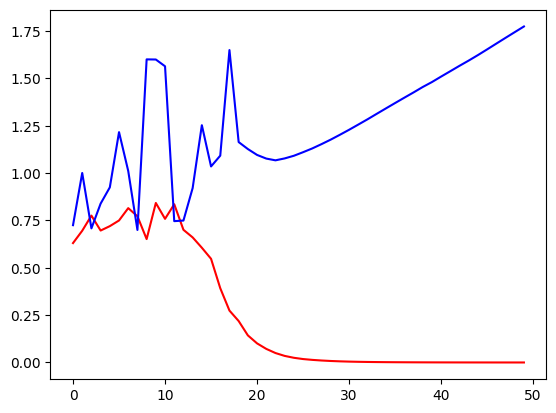

In [8]:
import matplotlib.pyplot as plt
plt.plot(trainLosses, color = 'r')
plt.plot(testLosses, color = 'b')
plt.show()

In [9]:
with torch.no_grad():
    correct = 0.
    for x,y in trainDataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = torch.sigmoid(model(x))
        correct += ((pred > 0.5) == y).type(torch.float32).sum()
    acc = correct/len(trainDataloader.dataset)
    print(f'Acc is {acc}')
    print(f'Correct = {correct}')
    print(f'Total {len(trainDataloader.dataset)}')

Acc is 1.0
Correct = 7108.0
Total 7108


In [10]:
with torch.no_grad():
    correct = 0.
    for x,y in testDataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred = torch.sigmoid(model(x))
        correct += ((pred > 0.5) == y).type(torch.float32).sum()
    acc = correct/len(testDataloader.dataset)
    print(f'Acc is {acc}')
    print(f'Correct = {correct}')
    print(f'Total {len(testDataloader.dataset)}')

Acc is 0.7003376483917236
Correct = 2489.0
Total 3554


In [21]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

In [22]:
with torch.no_grad():
    x, y = testDataloader.dataset[:]
    x = x.to(DEVICE)
    pred = torch.sigmoid(model(x))
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score=pred)
    print(fpr)
    print(tpr)
    print(thr)

0.7677349766240231
[0.         0.00506472 0.00900394 ... 0.98761958 0.98761958 1.        ]
[0.         0.08328644 0.10241981 ... 0.99943725 1.         1.        ]
[2.0000000e+00 1.0000000e+00 9.9999988e-01 ... 1.9314453e-10 1.9273716e-10
 6.6439950e-14]


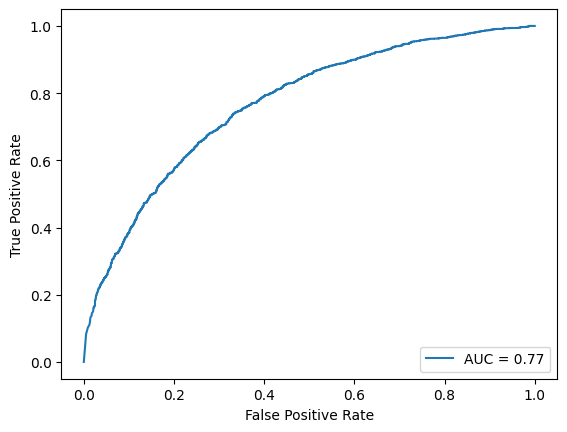

In [24]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()